In [1]:
import pandas as pd
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

/home/laurenz/.cache/pypoetry/virtualenvs/music-processing-6AESlpXO-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/processed/train/data.csv', low_memory=False)
df_val = pd.read_csv('../data/processed/val/data.csv', low_memory=False)
df.head()

,file,superflux,energy,rms,sound_preassure_level,welch,mean,kurtosis,skew,variation,onset,timestamps
0,train15,0.00000,8.041827e+09,3488.6445,-27.99103,0.24566,7.27979,5.66854,0.66392,214.39178,True,0.05
1,train15,0.19733,9.045935e+10,3897.6077,-23.72058,0.51078,-7.27783,5.36980,-0.26708,-24.42528,False,0.15
2,train15,0.00524,1.485465e+10,7424.0470,-24.04445,0.46147,-128.42920,-0.45575,-0.06433,-8.65492,False,0.25
3,train15,0.24321,9.432419e+09,4177.3193,-24.45488,0.50651,88.71777,0.35231,-0.06460,-16.05690,True,0.35
4,train15,0.00758,1.265973e+10,4192.2030,-24.37645,0.51467,84.33740,-0.21253,-0.49508,14.18289,True,0.45


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19856 entries, 0 to 19855
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   file                   19856 non-null  object 
 1   superflux              19856 non-null  float64
 2   energy                 19856 non-null  float64
 3   rms                    19856 non-null  float64
 4   sound_preassure_level  19856 non-null  float64
 5   welch                  19856 non-null  float64
 6   mean                   19856 non-null  float64
 7   kurtosis               19856 non-null  float64
 8   skew                   19856 non-null  float64
 9   variation              19846 non-null  float64
 10  onset                  19856 non-null  bool   
 11  timestamps             19856 non-null  float64
dtypes: bool(1), float64(10), object(1)
memory usage: 1.7+ MB


In [4]:
train_len = len(df)

In [5]:
df = pd.concat([df, df_val])

In [6]:
splits = (list(range_of(df)[:train_len]),list(range_of(df)[train_len:]))

In [7]:
procs = [Normalize]

In [8]:
cont,cat = cont_cat_split(df.loc[:, ~df.columns.isin(['file', 'timestamps', 'sound_preassure_level', 'variation'])], 1, dep_var="onset")

In [9]:
cont

['superflux', 'energy', 'rms', 'welch', 'mean', 'kurtosis', 'skew']

In [10]:
cat

[]

In [11]:
to = TabularPandas(df, procs=procs, cont_names=cont, y_names="onset", splits=splits)

In [12]:
len(to.train),len(to.valid)

(19856, 4630)

In [13]:
to.show(3)

,superflux,energy,rms,welch,mean,kurtosis,skew,onset
0,0.00000,8.041828e+09,3488.644531,0.0,7.279790,5.66854,0.66392,True
1,0.19733,9.045935e+10,3897.607666,0.0,-7.277830,5.36980,-0.26708,False
2,0.00524,1.485465e+10,7424.046875,0.0,-128.429199,-0.45575,-0.06433,False


In [14]:
to.items.head(3)

,file,superflux,energy,rms,sound_preassure_level,welch,mean,kurtosis,skew,variation,onset,timestamps
0,train15,-0.670074,-0.609744,-0.095604,-27.99103,-0.784001,0.014797,0.155890,0.814762,214.39178,1,0.05
1,train15,2.126108,0.820825,0.058200,-23.72058,-0.784001,-0.044730,0.146708,-0.361269,-24.42528,0,0.15
2,train15,-0.595823,-0.491490,1.384431,-24.04445,-0.784001,-0.540126,-0.032348,-0.105157,-8.65492,0,0.25


In [15]:
dls = to.dataloaders(bs=32)

In [16]:
learn = tabular_learner(dls, metrics=accuracy)

In [17]:
learn.summary()

TabularModel (Input shape: 32 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 7              
BatchNorm1d                               14         True      
____________________________________________________________________________
                     32 x 200            
Linear                                    1400       True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     32 x 100            
Linear                                    20000      True      
ReLU                                                           
BatchNorm1d                               200        True      
____________________________________________________________________________
                     32 x 2              
Linear                                    202        T

SuggestedLRs(valley=0.00013182566908653826)

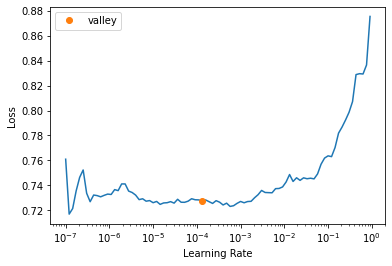

In [18]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(8, 4e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.703789,0.728256,0.494816,00:05
1,0.702609,0.706204,0.515119,00:04
2,0.695619,0.693647,0.538445,00:04
3,0.694612,0.710364,0.497408,00:04
4,0.689514,0.699072,0.522030,00:06
5,0.688843,0.696558,0.535205,00:05
6,0.688795,0.695338,0.519654,00:06
7,0.686691,0.694667,0.532829,00:06


In [20]:
learn.show_results()

,superflux,energy,rms,welch,mean,kurtosis,skew,onset,onset_pred
0,-0.585621,1.241753,-1.382327,0.690148,-0.036462,-0.022995,-0.130206,1.0,1.0
1,-0.419264,-0.748724,0.455100,0.311419,-0.268055,0.064341,0.056532,0.0,0.0
2,1.118899,-0.607569,2.225462,-0.273796,1.578186,0.064894,-0.164186,1.0,1.0
3,-0.469568,-0.746667,-1.382266,2.425746,3.255754,-0.034821,-0.609738,1.0,0.0
4,-0.010315,-0.685565,-0.346238,-0.392152,-0.593635,-0.027248,-0.448997,0.0,0.0
5,-0.486855,2.005907,-1.382439,1.383525,0.568511,-0.028460,0.008796,1.0,0.0
6,0.445111,1.942714,-0.082536,0.698505,0.782173,-0.017767,-0.315187,0.0,0.0
7,-0.216207,0.501175,-0.440851,0.209851,0.258555,0.168879,-0.076318,0.0,0.0
8,-0.670074,-0.596742,-0.420337,-0.434150,-0.068504,0.016250,0.700532,0.0,0.0


In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.show_results(list(range(8)))

,superflux,energy,rms,welch,mean,kurtosis,skew,onset,onset_pred
0,-0.670074,-0.427476,3.041081,-0.137541,-0.415659,0.098132,0.078031,1.0,1.0
1,8.827141,0.252990,1.866676,0.350330,-0.100777,-0.008538,-0.241531,0.0,0.0
2,-0.665823,-0.007671,1.336455,-0.088500,0.168522,-0.022503,0.539841,1.0,0.0
3,-0.667666,-0.089012,0.432287,-0.065466,1.565494,0.002527,0.005385,1.0,1.0
4,5.604297,-0.184789,0.143720,-0.311750,1.000880,-0.024216,-0.810345,0.0,0.0
5,-0.078332,0.109082,1.012764,-0.438487,-0.419347,-0.045418,-0.140993,1.0,1.0
6,0.153207,-0.386809,1.813244,-0.565146,0.198367,-0.033652,-0.061526,0.0,1.0
7,-0.001813,-0.612828,3.157516,-0.550809,0.204697,-0.002871,-0.351833,1.0,1.0


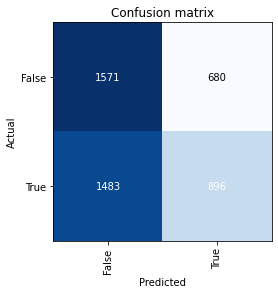

In [22]:
interp.plot_confusion_matrix()

In [23]:
learn.save('tabular')

Path('models/tabular.pth')

In [24]:
learn = learn.load("tabular")

In [25]:
test_df = pd.read_csv('../data/processed/test/data.csv', low_memory=False)
dl = learn.dls.test_dl(test_df)

In [26]:
learn.get_preds(dl=dl)

(tensor([[0.5373, 0.4627],
         [0.5087, 0.4913],
         [0.4924, 0.5076],
         ...,
         [0.4891, 0.5109],
         [0.4145, 0.5855],
         [0.5092, 0.4908]]),
 None)

In [27]:
# decision tree
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

In [28]:
def rf(xs, y, n_estimators=40, max_samples=train_len,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

m = rf(xs, y);

In [29]:
m

RandomForestRegressor(max_features=0.5, max_samples=19856, min_samples_leaf=5,
                      n_estimators=40, n_jobs=-1, oob_score=True)